In [1]:
# (token方向に)AvgPool -> (embed方向に)LayerNorm
# 0.1はwarmup
# gradient_accumulation_steps = 2

Credits to: https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-w-w-b-train and https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

I just applied Abhishek's great code to Nakama's great notebook to create folds grouped by anchors and stratified by score. Does this close the CV-LB gap? Let's see :-)

# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

In [2]:
# ====================================================
# CFG
# ====================================================
class CFG:
    
    # General
    exp='026'
    debug=False  # False
    wandb=True
    resume= None  # [None, 'auto', 'allow', 'must']
    save_checkpoint=True
    competition='PPPM'
    seed=42

    # Dataset & DataLoader
    tokenizer_kwargs={
        'do_lower_case': True,
    }
    num_workers=4
    batch_size=16
    max_len=512

    # Model
    model="microsoft/deberta-v3-large"
    fc_dropout=0.2
    target_size=1

    # Optimizer & Scheduler
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    weight_decay=0.01
    max_grad_norm=1000

    # Train
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    epochs=5
    gradient_accumulation_steps=2
    print_freq=100
    apex=True
    train=True
    

if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]


# ====================================================
# Colab settings
# ====================================================
class ColabConfig:
    dataset_name = CFG.competition
    dataset_version = 'exp' + CFG.exp
    dataset_new = True  # 新しいデータセットか
    dataset_dir = None  # Kaggle Dataset にアップロードするディレクトリ
    dataset_note = ''  # 前の版からの変更点
    in_colab = False  # colab上にデータダウンロード

In [3]:
!nvcc --version
!python -c 'import torch; print(torch.__version__) '
!python --version
print('')
!nvidia-smi
print('')
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
1.11.0+cu113
Python 3.7.13

Thu Jun 16 14:48:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                

In [4]:
%%time
import sys
COLAB = "google.colab" in sys.modules

if COLAB:
    import os
    print('This environment is Google Colab')

    # mount drive
    from google.colab import drive
    if not os.path.isdir('/content/drive'):
        drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/kaggle/PPPM/exps')

    # kaggle api token and update kaggle api
    from google.colab import files
    if not os.path.isfile('~/.kaggle/kaggle.json'):
        # files.upload()
        !mkdir -p ~/.kaggle
        !cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        !pip install --upgrade --force-reinstall --no-deps -q kaggle

    if ColabConfig.in_colab:
        # make directory in colab
        !mkdir -p /content/input
        !mkdir -p /content/working

        # download dataset in colab
        import zipfile, glob
        os.chdir('/content/input')
        # !kaggle competitions download -qc birdclef-2022 -p birdclef-2022
        
        # !mkdir birdclef-2022
        # !cp /content/drive/MyDrive/kaggle/BirdCLEF2022/input/birdclef-2022/* ./birdclef-2022/

        for p in glob.glob('**/*.zip', recursive=True):
            print(p)
            d, f = os.path.split(p)
            # if f in ['']:
            #     continue
            with zipfile.ZipFile(p, 'r') as zipf:
                print('unzip: ', zipf)
                zipf.extractall(d)
                print('remove: ', f)
                os.remove(p)
        
        os.chdir('/content/working')

This environment is Google Colab
CPU times: user 27 ms, sys: 16 ms, total: 43 ms
Wall time: 2.15 s


In [5]:
# ====================================================
# Directory settings
# ====================================================
import os

INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
OUTPUT_DIR = f'/content/drive/MyDrive/kaggle/PPPM/output/{CFG.exp}/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# kaggle dataset config
ColabConfig.dataset_dir = OUTPUT_DIR

# WandB

In [6]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    !pip install -q wandb
    import wandb

    if CFG.debug:
        anony = "must"
        print('It is debugging.')
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')
    else:
        try:
            # from kaggle_secrets import UserSecretsClient
            # user_secrets = UserSecretsClient()
            # secret_value_0 = user_secrets.get_secret("wandb_api")
            with open('/content/drive/MyDrive/kaggle/wandb') as f:
                wandb_api_key = f.readline().rstrip('\n')
            wandb.login(key=wandb_api_key)
            anony = None
        except:
            anony = "must"
            print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    # https://docs.wandb.ai/ref/python/init
    run = wandb.init(project='PPPM', 
                        name=CFG.exp,
                        config=class2dict(CFG),
                    #  group=CFG.exp,
                        job_type="train",
                        resume=CFG.resume,  # 'auto'
                        # id='3bwalqa8',
                        anonymous=anony)

wandb: Currently logged in as: y-haneji. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Library

In [ ]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
tqdm.pandas()
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

# # 20分ぐらい
# !pip uninstall -y torch torchvision
# !pip install 'https://download.pytorch.org/whl/cu111/torch-1.10.2%2Bcu111-cp37-cp37m-linux_x86_64.whl' 'https://download.pytorch.org/whl/cu111/torchvision-0.11.3%2Bcu111-cp37-cp37m-linux_x86_64.whl'
# !git clone https://github.com/NVIDIA/apex.git
# %cd apex
# !pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" .
# %cd ..
# # !rm -rf /content/drive/MyDrive/kaggle/PPPM/exps/apex/
# from apex import amp

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

os.system('python -m pip install sentencepiece')
os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels transformers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels tokenizers')
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Utils

In [ ]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [ ]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

In [ ]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

In [11]:
# ';' を ',' に変換する
def preprocess_context(text: str):
    text = text.replace(';', '.')
    return text

train['context_text'] = train['context_text'].map(preprocess_context)
test['context_text'] = test['context_text'].map(preprocess_context)

In [ ]:
# anchor, target, context_text をそれぞれ一文ずつとみなす
# anchorとtarget逆順にも並べる
train['text'] = train['anchor'] + '.' + ' [SEP] ' + train['target'] + '.' + ' [SEP] '  + train['context_text'] + '.'
test['text'] = test['anchor'] + '.' + ' [SEP] ' + test['target'] + '.' + ' [SEP] '  + test['context_text'] + '.'
train['text_rev'] = train['target'] + '.' + ' [SEP] ' + train['anchor'] + '.' + ' [SEP] '  + train['context_text'] + '.'
test['text_rev'] = test['target'] + '.' + ' [SEP] ' + test['anchor'] + '.' + ' [SEP] '  + test['context_text'] + '.'
display(train.head())
display(test.head())

# EDA

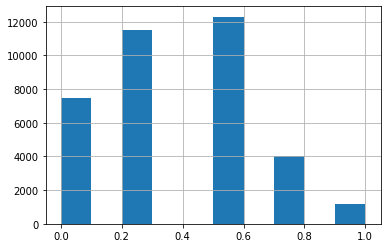

In [13]:
train['score'].hist()

In [14]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [15]:
#credits to: https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

!pip install -q iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

dfx = pd.get_dummies(train, columns=["score"]).groupby(["anchor"], as_index=False).sum()
cols = [c for c in dfx.columns if c.startswith("score_") or c == "anchor"]
dfx = dfx[cols]

mskf = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
labels = [c for c in dfx.columns if c != "anchor"]
dfx_labels = dfx[labels]
dfx["fold"] = -1

for fold, (trn_, val_) in enumerate(mskf.split(dfx, dfx_labels)):
    print(len(trn_), len(val_))
    dfx.loc[val_, "fold"] = fold

train = train.merge(dfx[["anchor", "fold"]], on="anchor", how="left")
print(train.fold.value_counts())

550 183
549 184
550 183
550 183
3    9622
0    9379
1    8860
2    8612
Name: fold, dtype: int64


In [16]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [17]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model, **CFG.tokenizer_kwargs)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [18]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 106


In [ ]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df, phase: str ='train'):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [ ]:
# train_dataset = TrainDataset(CFG, train, 'train')
# inputs, label = train_dataset[0]
# print(inputs)
# print(label)

# Model

In [ ]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self.layer_norm1 = nn.LayerNorm(self.config.hidden_size)
        self._init_weights(self.attention)
        self.linear = nn.Linear(self.config.hidden_size, 1)
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_state = outputs[0]
        input_mask_expanded = inputs["attention_mask"].unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        out = sum_embeddings / sum_mask
        
        out = self.layer_norm1(out)
        output = self.fc(out)
                
        return output

# Helpler functions

In [ ]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [ ]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold, checkpoint_path=None,):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds, phase='train')
    valid_dataset = TrainDataset(CFG, valid_folds, phase='val')

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size / CFG.gradient_accumulation_steps * CFG.epochs)
    CFG.num_warmup_steps = num_train_steps * 0.1
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.
    epoch = 0

    # if wandb.run.resumed:
    #     checkpoint = torch.load(checkpoint_path)  # wandb.restore(checkpoint_path)
    #     if checkpoint['epoch'] < CFG.epochs-1:  # foldの終わりで止まっている時もある
    #         model.load_state_dict(checkpoint['model'])
    #         optimizer.load_state_dict(checkpoint['optimizer'])
    #         scheduler.load_state_dict(checkpoint['scheduler'])
    #         # amp.load_state_dict(checkpoint['amp'])
    #         epoch = checkpoint['epoch'] + 1  # 保存時のエポックが読み出されるので+1
    #         best_score = checkpoint['best_score']

    while epoch < CFG.epochs:
        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if CFG.save_checkpoint:
            torch.save({'model': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'scheduler': scheduler.state_dict(),
                        # 'amp': amp.state_dict(),
                        'epoch': epoch,
                        'best_score': best_score},
                        checkpoint_path)
            # wandb.save(checkpoint_path)  # driveでos.symlinkでエラーが出る

        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
            
        epoch += 1

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [24]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        fold = 0

        if wandb.run.resumed:
            checkpoint = torch.load(OUTPUT_DIR + 'fold_checkpoint.pth')
            fold = checkpoint['fold'] + 1  # 保存時のfoldが読み出されるので+1
            oof_df = checkpoint['oof_df']

        while fold < CFG.n_fold:
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold, checkpoint_path=OUTPUT_DIR + 'epoch_checkpoint.pth')
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
            if CFG.save_checkpoint:
                torch.save({'fold': fold,
                            'oof_df': oof_df},
                            OUTPUT_DIR + 'fold_checkpoint.pth')
            fold += 1

        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb & (~CFG.debug):
        wandb.finish()

    os.remove(OUTPUT_DIR + 'fold_checkpoint.pth')
    os.remove(OUTPUT_DIR + 'epoch_checkpoint.pth')

========== fold: 0 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClas

Epoch: [1][0/1693] Elapsed 0m 0s (remain 21m 7s) Loss: 0.3491(0.3491) Grad: inf  LR: 0.00000000  
Epoch: [1][100/1693] Elapsed 0m 52s (remain 13m 47s) Loss: 0.3088(0.3366) Grad: 18116.1191  LR: 0.00000236  
Epoch: [1][200/1693] Elapsed 1m 44s (remain 12m 56s) Loss: 0.2930(0.3281) Grad: 23166.3105  LR: 0.00000472  
Epoch: [1][300/1693] Elapsed 2m 36s (remain 12m 5s) Loss: 0.3023(0.3216) Grad: 11272.8584  LR: 0.00000709  
Epoch: [1][400/1693] Elapsed 3m 28s (remain 11m 12s) Loss: 0.2849(0.3163) Grad: 26281.5547  LR: 0.00000945  
Epoch: [1][500/1693] Elapsed 4m 20s (remain 10m 20s) Loss: 0.3237(0.3114) Grad: 25617.8516  LR: 0.00001181  
Epoch: [1][600/1693] Elapsed 5m 13s (remain 9m 28s) Loss: 0.3053(0.3089) Grad: 39213.6953  LR: 0.00001417  
Epoch: [1][700/1693] Elapsed 6m 5s (remain 8m 37s) Loss: 0.2750(0.3071) Grad: 16261.5801  LR: 0.00001654  
Epoch: [1][800/1693] Elapsed 6m 57s (remain 7m 45s) Loss: 0.3020(0.3052) Grad: 15411.0137  LR: 0.00001890  
Epoch: [1][900/1693] Elapsed 7m 49s

Epoch 1 - avg_train_loss: 0.2918  avg_val_loss: 0.2746  time: 1134s
Epoch 1 - Score: 0.8135


EVAL: [586/587] Elapsed 4m 11s (remain 0m 0s) Loss: 0.3383(0.2746) 


Epoch 1 - Save Best Score: 0.8135 Model


Epoch: [2][0/1693] Elapsed 0m 0s (remain 25m 59s) Loss: 0.3109(0.3109) Grad: 37382.5898  LR: 0.00001940  
Epoch: [2][100/1693] Elapsed 0m 54s (remain 14m 23s) Loss: 0.2977(0.2687) Grad: 90213.7891  LR: 0.00001925  
Epoch: [2][200/1693] Elapsed 1m 47s (remain 13m 17s) Loss: 0.2627(0.2694) Grad: 61544.0742  LR: 0.00001909  
Epoch: [2][300/1693] Elapsed 2m 39s (remain 12m 18s) Loss: 0.2810(0.2692) Grad: 113176.2266  LR: 0.00001891  
Epoch: [2][400/1693] Elapsed 3m 31s (remain 11m 22s) Loss: 0.2928(0.2688) Grad: 62665.8555  LR: 0.00001871  
Epoch: [2][500/1693] Elapsed 4m 24s (remain 10m 28s) Loss: 0.2317(0.2690) Grad: 40424.6680  LR: 0.00001850  
Epoch: [2][600/1693] Elapsed 5m 16s (remain 9m 34s) Loss: 0.2765(0.2684) Grad: 68505.2266  LR: 0.00001828  
Epoch: [2][700/1693] Elapsed 6m 8s (remain 8m 41s) Loss: 0.2542(0.2672) Grad: 30611.3867  LR: 0.00001804  
Epoch: [2][800/1693] Elapsed 7m 0s (remain 7m 48s) Loss: 0.2647(0.2665) Grad: 84428.4375  LR: 0.00001779  
Epoch: [2][900/1693] Elaps

Epoch 2 - avg_train_loss: 0.2659  avg_val_loss: 0.2703  time: 1137s
Epoch 2 - Score: 0.8363


EVAL: [586/587] Elapsed 4m 10s (remain 0m 0s) Loss: 0.3338(0.2703) 


Epoch 2 - Save Best Score: 0.8363 Model


Epoch: [3][0/1693] Elapsed 0m 0s (remain 22m 39s) Loss: 0.3007(0.3007) Grad: 82659.4844  LR: 0.00001501  
Epoch: [3][100/1693] Elapsed 0m 53s (remain 14m 8s) Loss: 0.2522(0.2638) Grad: 24438.7266  LR: 0.00001465  
Epoch: [3][200/1693] Elapsed 1m 46s (remain 13m 9s) Loss: 0.2930(0.2626) Grad: 28144.6953  LR: 0.00001428  
Epoch: [3][300/1693] Elapsed 2m 39s (remain 12m 16s) Loss: 0.3361(0.2608) Grad: 182617.7812  LR: 0.00001390  
Epoch: [3][400/1693] Elapsed 3m 31s (remain 11m 22s) Loss: 0.2404(0.2602) Grad: 49770.0742  LR: 0.00001352  
Epoch: [3][500/1693] Elapsed 4m 23s (remain 10m 27s) Loss: 0.2612(0.2611) Grad: 40999.9805  LR: 0.00001313  
Epoch: [3][600/1693] Elapsed 5m 15s (remain 9m 33s) Loss: 0.2150(0.2599) Grad: 38056.2070  LR: 0.00001274  
Epoch: [3][700/1693] Elapsed 6m 8s (remain 8m 40s) Loss: 0.2406(0.2598) Grad: 59966.0352  LR: 0.00001234  
Epoch: [3][800/1693] Elapsed 7m 0s (remain 7m 47s) Loss: 0.2992(0.2595) Grad: 39236.4531  LR: 0.00001194  
Epoch: [3][900/1693] Elapsed

Epoch 3 - avg_train_loss: 0.2605  avg_val_loss: 0.2729  time: 1137s
Epoch 3 - Score: 0.8375


EVAL: [586/587] Elapsed 4m 11s (remain 0m 0s) Loss: 0.3343(0.2729) 


Epoch 3 - Save Best Score: 0.8375 Model


Epoch: [4][0/1693] Elapsed 0m 1s (remain 34m 28s) Loss: 0.3065(0.3065) Grad: 20809.8301  LR: 0.00000828  
Epoch: [4][100/1693] Elapsed 0m 54s (remain 14m 15s) Loss: 0.2684(0.2584) Grad: 41816.8203  LR: 0.00000787  
Epoch: [4][200/1693] Elapsed 1m 46s (remain 13m 12s) Loss: 0.2918(0.2571) Grad: 37509.9727  LR: 0.00000747  
Epoch: [4][300/1693] Elapsed 2m 39s (remain 12m 17s) Loss: 0.2568(0.2575) Grad: 92095.6406  LR: 0.00000708  
Epoch: [4][400/1693] Elapsed 3m 32s (remain 11m 23s) Loss: 0.2059(0.2580) Grad: 22113.2285  LR: 0.00000668  
Epoch: [4][500/1693] Elapsed 4m 24s (remain 10m 28s) Loss: 0.3064(0.2568) Grad: 126525.7031  LR: 0.00000630  
Epoch: [4][600/1693] Elapsed 5m 16s (remain 9m 34s) Loss: 0.2501(0.2570) Grad: 98639.5000  LR: 0.00000592  
Epoch: [4][700/1693] Elapsed 6m 8s (remain 8m 41s) Loss: 0.2312(0.2569) Grad: 63566.0391  LR: 0.00000555  
Epoch: [4][800/1693] Elapsed 7m 0s (remain 7m 48s) Loss: 0.2005(0.2560) Grad: 111683.0156  LR: 0.00000518  
Epoch: [4][900/1693] Elap

Epoch 4 - avg_train_loss: 0.2565  avg_val_loss: 0.2721  time: 1137s
Epoch 4 - Score: 0.8429


EVAL: [586/587] Elapsed 4m 10s (remain 0m 0s) Loss: 0.3338(0.2721) 


Epoch 4 - Save Best Score: 0.8429 Model


Epoch: [5][0/1693] Elapsed 0m 0s (remain 24m 49s) Loss: 0.2541(0.2541) Grad: 34088.9844  LR: 0.00000235  
Epoch: [5][100/1693] Elapsed 0m 53s (remain 14m 5s) Loss: 0.2678(0.2499) Grad: 47655.3477  LR: 0.00000209  
Epoch: [5][200/1693] Elapsed 1m 46s (remain 13m 7s) Loss: 0.2541(0.2501) Grad: 63235.8008  LR: 0.00000185  
Epoch: [5][300/1693] Elapsed 2m 38s (remain 12m 13s) Loss: 0.3083(0.2515) Grad: 135518.0000  LR: 0.00000162  
Epoch: [5][400/1693] Elapsed 3m 31s (remain 11m 20s) Loss: 0.3143(0.2531) Grad: 235768.0781  LR: 0.00000140  
Epoch: [5][500/1693] Elapsed 4m 23s (remain 10m 25s) Loss: 0.3030(0.2532) Grad: 36227.4805  LR: 0.00000120  
Epoch: [5][600/1693] Elapsed 5m 15s (remain 9m 32s) Loss: 0.3043(0.2528) Grad: 26253.3477  LR: 0.00000101  
Epoch: [5][700/1693] Elapsed 6m 7s (remain 8m 39s) Loss: 0.2796(0.2529) Grad: 49590.4766  LR: 0.00000083  
Epoch: [5][800/1693] Elapsed 6m 59s (remain 7m 46s) Loss: 0.2830(0.2527) Grad: 56050.9180  LR: 0.00000068  
Epoch: [5][900/1693] Elaps

Epoch 5 - avg_train_loss: 0.2543  avg_val_loss: 0.2734  time: 1135s
Epoch 5 - Score: 0.8415


EVAL: [586/587] Elapsed 4m 10s (remain 0m 0s) Loss: 0.3338(0.2734) 


========== fold: 0 result ==========
Score: 0.8429
========== fold: 1 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/1725] Elapsed 0m 0s (remain 26m 10s) Loss: 0.3337(0.3337) Grad: 74302.0078  LR: 0.00000000  
Epoch: [1][100/1725] Elapsed 0m 54s (remain 14m 29s) Loss: 0.3345(0.3230) Grad: 24443.4473  LR: 0.00000232  
Epoch: [1][200/1725] Elapsed 1m 46s (remain 13m 29s) Loss: 0.3364(0.3229) Grad: 22803.2754  LR: 0.00000464  
Epoch: [1][300/1725] Elapsed 2m 38s (remain 12m 30s) Loss: 0.3004(0.3197) Grad: 10674.1006  LR: 0.00000695  
Epoch: [1][400/1725] Elapsed 3m 30s (remain 11m 35s) Loss: 0.2972(0.3162) Grad: 14744.3027  LR: 0.00000927  
Epoch: [1][500/1725] Elapsed 4m 22s (remain 10m 41s) Loss: 0.2627(0.3119) Grad: 22604.1387  LR: 0.00001159  
Epoch: [1][600/1725] Elapsed 5m 14s (remain 9m 48s) Loss: 0.2940(0.3084) Grad: 12752.8154  LR: 0.00001391  
Epoch: [1][700/1725] Elapsed 6m 6s (remain 8m 56s) Loss: 0.3376(0.3057) Grad: 43142.7578  LR: 0.00001623  
Epoch: [1][800/1725] Elapsed 6m 59s (remain 8m 3s) Loss: 0.2741(0.3040) Grad: 12302.9932  LR: 0.00001854  
Epoch: [1][900/1725] Elapse

Epoch 1 - avg_train_loss: 0.2896  avg_val_loss: 0.2761  time: 1138s
Epoch 1 - Score: 0.7970


EVAL: [553/554] Elapsed 3m 56s (remain 0m 0s) Loss: 0.2529(0.2761) 


Epoch 1 - Save Best Score: 0.7970 Model


Epoch: [2][0/1725] Elapsed 0m 0s (remain 22m 53s) Loss: 0.3129(0.3129) Grad: 37384.4023  LR: 0.00001940  
Epoch: [2][100/1725] Elapsed 0m 54s (remain 14m 28s) Loss: 0.2625(0.2782) Grad: 22128.2754  LR: 0.00001925  
Epoch: [2][200/1725] Elapsed 1m 46s (remain 13m 27s) Loss: 0.2653(0.2744) Grad: 24413.3281  LR: 0.00001909  
Epoch: [2][300/1725] Elapsed 2m 38s (remain 12m 32s) Loss: 0.3118(0.2690) Grad: 45251.0508  LR: 0.00001892  
Epoch: [2][400/1725] Elapsed 3m 31s (remain 11m 37s) Loss: 0.3175(0.2686) Grad: 24689.8262  LR: 0.00001873  
Epoch: [2][500/1725] Elapsed 4m 23s (remain 10m 42s) Loss: 0.2669(0.2692) Grad: 15998.7822  LR: 0.00001852  
Epoch: [2][600/1725] Elapsed 5m 15s (remain 9m 49s) Loss: 0.3360(0.2697) Grad: 46539.5430  LR: 0.00001830  
Epoch: [2][700/1725] Elapsed 6m 7s (remain 8m 56s) Loss: 0.2721(0.2697) Grad: 18478.2539  LR: 0.00001807  
Epoch: [2][800/1725] Elapsed 6m 59s (remain 8m 4s) Loss: 0.2350(0.2692) Grad: 21800.9609  LR: 0.00001783  
Epoch: [2][900/1725] Elapse

Epoch 2 - avg_train_loss: 0.2662  avg_val_loss: 0.2726  time: 1139s
Epoch 2 - Score: 0.8174


EVAL: [553/554] Elapsed 3m 57s (remain 0m 0s) Loss: 0.2542(0.2726) 


Epoch 2 - Save Best Score: 0.8174 Model


Epoch: [3][0/1725] Elapsed 0m 0s (remain 25m 34s) Loss: 0.2736(0.2736) Grad: 83156.9062  LR: 0.00001501  
Epoch: [3][100/1725] Elapsed 0m 53s (remain 14m 27s) Loss: 0.3181(0.2620) Grad: 64309.8594  LR: 0.00001466  
Epoch: [3][200/1725] Elapsed 1m 46s (remain 13m 30s) Loss: 0.3006(0.2624) Grad: 55047.1758  LR: 0.00001430  
Epoch: [3][300/1725] Elapsed 2m 39s (remain 12m 36s) Loss: 0.2830(0.2614) Grad: 32666.8398  LR: 0.00001393  
Epoch: [3][400/1725] Elapsed 3m 32s (remain 11m 40s) Loss: 0.2333(0.2611) Grad: 125616.7578  LR: 0.00001355  
Epoch: [3][500/1725] Elapsed 4m 24s (remain 10m 45s) Loss: 0.2104(0.2604) Grad: 45639.5078  LR: 0.00001317  
Epoch: [3][600/1725] Elapsed 5m 16s (remain 9m 51s) Loss: 0.2641(0.2599) Grad: 125769.5312  LR: 0.00001278  
Epoch: [3][700/1725] Elapsed 6m 8s (remain 8m 58s) Loss: 0.2733(0.2600) Grad: 84273.1406  LR: 0.00001239  
Epoch: [3][800/1725] Elapsed 7m 0s (remain 8m 5s) Loss: 0.3163(0.2603) Grad: 80911.7500  LR: 0.00001200  
Epoch: [3][900/1725] Elaps

Epoch 3 - avg_train_loss: 0.2587  avg_val_loss: 0.2755  time: 1140s
Epoch 3 - Score: 0.8254


EVAL: [553/554] Elapsed 3m 57s (remain 0m 0s) Loss: 0.2483(0.2755) 


Epoch 3 - Save Best Score: 0.8254 Model


Epoch: [4][0/1725] Elapsed 0m 0s (remain 22m 27s) Loss: 0.3011(0.3011) Grad: 49668.9219  LR: 0.00000828  
Epoch: [4][100/1725] Elapsed 0m 53s (remain 14m 26s) Loss: 0.2808(0.2586) Grad: 34232.7930  LR: 0.00000789  
Epoch: [4][200/1725] Elapsed 1m 46s (remain 13m 28s) Loss: 0.2690(0.2568) Grad: 48915.7383  LR: 0.00000749  
Epoch: [4][300/1725] Elapsed 2m 39s (remain 12m 34s) Loss: 0.2519(0.2565) Grad: 13419.4502  LR: 0.00000710  
Epoch: [4][400/1725] Elapsed 3m 31s (remain 11m 38s) Loss: 0.2391(0.2568) Grad: 38246.6758  LR: 0.00000672  
Epoch: [4][500/1725] Elapsed 4m 23s (remain 10m 44s) Loss: 0.2709(0.2580) Grad: 71778.4609  LR: 0.00000634  
Epoch: [4][600/1725] Elapsed 5m 15s (remain 9m 50s) Loss: 0.2049(0.2570) Grad: 235264.8750  LR: 0.00000597  
Epoch: [4][700/1725] Elapsed 6m 8s (remain 8m 57s) Loss: 0.2788(0.2572) Grad: 53047.2578  LR: 0.00000560  
Epoch: [4][800/1725] Elapsed 7m 0s (remain 8m 4s) Loss: 0.2574(0.2563) Grad: 18728.1797  LR: 0.00000524  
Epoch: [4][900/1725] Elapse

Epoch 4 - avg_train_loss: 0.2549  avg_val_loss: 0.2768  time: 1139s
Epoch 4 - Score: 0.8282


EVAL: [553/554] Elapsed 3m 56s (remain 0m 0s) Loss: 0.2481(0.2768) 


Epoch 4 - Save Best Score: 0.8282 Model


Epoch: [5][0/1725] Elapsed 0m 0s (remain 27m 53s) Loss: 0.1513(0.1513) Grad: 25334.0762  LR: 0.00000236  
Epoch: [5][100/1725] Elapsed 0m 54s (remain 14m 30s) Loss: 0.2754(0.2570) Grad: 28653.7383  LR: 0.00000210  
Epoch: [5][200/1725] Elapsed 1m 47s (remain 13m 31s) Loss: 0.2608(0.2572) Grad: 39697.1211  LR: 0.00000186  
Epoch: [5][300/1725] Elapsed 2m 40s (remain 12m 37s) Loss: 0.2353(0.2564) Grad: 25314.2480  LR: 0.00000163  
Epoch: [5][400/1725] Elapsed 3m 32s (remain 11m 41s) Loss: 0.2349(0.2547) Grad: 51002.1289  LR: 0.00000142  
Epoch: [5][500/1725] Elapsed 4m 24s (remain 10m 46s) Loss: 0.2677(0.2548) Grad: 29280.1426  LR: 0.00000122  
Epoch: [5][600/1725] Elapsed 5m 16s (remain 9m 52s) Loss: 0.2762(0.2546) Grad: 42569.0938  LR: 0.00000103  
Epoch: [5][700/1725] Elapsed 6m 8s (remain 8m 58s) Loss: 0.2794(0.2542) Grad: 13151.1055  LR: 0.00000086  
Epoch: [5][800/1725] Elapsed 7m 0s (remain 8m 5s) Loss: 0.2676(0.2541) Grad: 56209.7812  LR: 0.00000070  
Epoch: [5][900/1725] Elapsed

Epoch 5 - avg_train_loss: 0.2530  avg_val_loss: 0.2776  time: 1141s
Epoch 5 - Score: 0.8280


EVAL: [553/554] Elapsed 3m 57s (remain 0m 0s) Loss: 0.2473(0.2776) 


========== fold: 1 result ==========
Score: 0.8282
========== fold: 2 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/1741] Elapsed 0m 0s (remain 28m 17s) Loss: 0.3569(0.3569) Grad: inf  LR: 0.00000000  
Epoch: [1][100/1741] Elapsed 0m 53s (remain 14m 35s) Loss: 0.3542(0.3393) Grad: 30701.3184  LR: 0.00000230  
Epoch: [1][200/1741] Elapsed 1m 46s (remain 13m 36s) Loss: 0.3239(0.3316) Grad: 31859.7070  LR: 0.00000459  
Epoch: [1][300/1741] Elapsed 2m 38s (remain 12m 40s) Loss: 0.3336(0.3257) Grad: 15528.6816  LR: 0.00000689  
Epoch: [1][400/1741] Elapsed 3m 31s (remain 11m 45s) Loss: 0.3187(0.3197) Grad: 18815.2949  LR: 0.00000919  
Epoch: [1][500/1741] Elapsed 4m 23s (remain 10m 51s) Loss: 0.2996(0.3159) Grad: 66056.2109  LR: 0.00001149  
Epoch: [1][600/1741] Elapsed 5m 15s (remain 9m 58s) Loss: 0.3094(0.3120) Grad: 29298.1113  LR: 0.00001378  
Epoch: [1][700/1741] Elapsed 6m 7s (remain 9m 5s) Loss: 0.2863(0.3086) Grad: 27750.6562  LR: 0.00001608  
Epoch: [1][800/1741] Elapsed 6m 59s (remain 8m 12s) Loss: 0.2476(0.3056) Grad: 12747.6699  LR: 0.00001838  
Epoch: [1][900/1741] Elapsed 7m 51

Epoch 1 - avg_train_loss: 0.2912  avg_val_loss: 0.2768  time: 1141s
Epoch 1 - Score: 0.8125


EVAL: [538/539] Elapsed 3m 50s (remain 0m 0s) Loss: 0.1697(0.2768) 


Epoch 1 - Save Best Score: 0.8125 Model


Epoch: [2][0/1741] Elapsed 0m 0s (remain 24m 35s) Loss: 0.2673(0.2673) Grad: 104056.1328  LR: 0.00001940  
Epoch: [2][100/1741] Elapsed 0m 54s (remain 14m 43s) Loss: 0.2954(0.2639) Grad: 43393.7539  LR: 0.00001925  
Epoch: [2][200/1741] Elapsed 1m 46s (remain 13m 39s) Loss: 0.3573(0.2669) Grad: 218056.0156  LR: 0.00001909  
Epoch: [2][300/1741] Elapsed 2m 39s (remain 12m 42s) Loss: 0.2510(0.2650) Grad: 34303.3320  LR: 0.00001892  
Epoch: [2][400/1741] Elapsed 3m 31s (remain 11m 46s) Loss: 0.2828(0.2652) Grad: 53054.8398  LR: 0.00001873  
Epoch: [2][500/1741] Elapsed 4m 23s (remain 10m 52s) Loss: 0.2716(0.2658) Grad: 14272.1270  LR: 0.00001853  
Epoch: [2][600/1741] Elapsed 5m 15s (remain 9m 59s) Loss: 0.2627(0.2667) Grad: 36571.7891  LR: 0.00001831  
Epoch: [2][700/1741] Elapsed 6m 8s (remain 9m 6s) Loss: 0.2015(0.2663) Grad: 31910.7480  LR: 0.00001808  
Epoch: [2][800/1741] Elapsed 7m 0s (remain 8m 13s) Loss: 0.3292(0.2659) Grad: 62257.2188  LR: 0.00001784  
Epoch: [2][900/1741] Elaps

Epoch 2 - avg_train_loss: 0.2676  avg_val_loss: 0.2752  time: 1142s
Epoch 2 - Score: 0.8298


EVAL: [538/539] Elapsed 3m 50s (remain 0m 0s) Loss: 0.1638(0.2752) 


Epoch 2 - Save Best Score: 0.8298 Model


Epoch: [3][0/1741] Elapsed 0m 0s (remain 23m 48s) Loss: 0.3301(0.3301) Grad: 158531.8438  LR: 0.00001501  
Epoch: [3][100/1741] Elapsed 0m 54s (remain 14m 41s) Loss: 0.2589(0.2614) Grad: 44299.7383  LR: 0.00001466  
Epoch: [3][200/1741] Elapsed 1m 46s (remain 13m 39s) Loss: 0.2487(0.2609) Grad: 16879.6289  LR: 0.00001430  
Epoch: [3][300/1741] Elapsed 2m 39s (remain 12m 43s) Loss: 0.2265(0.2602) Grad: 40651.1914  LR: 0.00001393  
Epoch: [3][400/1741] Elapsed 3m 31s (remain 11m 47s) Loss: 0.3391(0.2611) Grad: 49870.6562  LR: 0.00001356  
Epoch: [3][500/1741] Elapsed 4m 23s (remain 10m 53s) Loss: 0.2629(0.2604) Grad: 47646.4961  LR: 0.00001318  
Epoch: [3][600/1741] Elapsed 5m 16s (remain 9m 59s) Loss: 0.2932(0.2616) Grad: 57246.7773  LR: 0.00001280  
Epoch: [3][700/1741] Elapsed 6m 8s (remain 9m 6s) Loss: 0.2353(0.2609) Grad: 22966.0625  LR: 0.00001241  
Epoch: [3][800/1741] Elapsed 7m 0s (remain 8m 13s) Loss: 0.2756(0.2611) Grad: 19910.1211  LR: 0.00001202  
Epoch: [3][900/1741] Elapse

Epoch 3 - avg_train_loss: 0.2613  avg_val_loss: 0.2705  time: 1142s
Epoch 3 - Score: 0.8411


EVAL: [538/539] Elapsed 3m 50s (remain 0m 0s) Loss: 0.1647(0.2705) 


Epoch 3 - Save Best Score: 0.8411 Model


Epoch: [4][0/1741] Elapsed 0m 0s (remain 26m 44s) Loss: 0.2241(0.2241) Grad: 75537.8906  LR: 0.00000828  
Epoch: [4][100/1741] Elapsed 0m 54s (remain 14m 37s) Loss: 0.2897(0.2591) Grad: 98830.0078  LR: 0.00000788  
Epoch: [4][200/1741] Elapsed 1m 46s (remain 13m 38s) Loss: 0.2487(0.2599) Grad: 38343.9805  LR: 0.00000749  
Epoch: [4][300/1741] Elapsed 2m 39s (remain 12m 43s) Loss: 0.2579(0.2581) Grad: 21554.3027  LR: 0.00000711  
Epoch: [4][400/1741] Elapsed 3m 31s (remain 11m 47s) Loss: 0.2787(0.2563) Grad: 65036.1836  LR: 0.00000673  
Epoch: [4][500/1741] Elapsed 4m 24s (remain 10m 53s) Loss: 0.2610(0.2562) Grad: 20942.2129  LR: 0.00000635  
Epoch: [4][600/1741] Elapsed 5m 16s (remain 9m 59s) Loss: 0.2638(0.2564) Grad: 44271.2695  LR: 0.00000598  
Epoch: [4][700/1741] Elapsed 6m 8s (remain 9m 6s) Loss: 0.2843(0.2569) Grad: 89620.9297  LR: 0.00000562  
Epoch: [4][800/1741] Elapsed 7m 0s (remain 8m 13s) Loss: 0.2548(0.2573) Grad: 48122.5391  LR: 0.00000526  
Epoch: [4][900/1741] Elapsed

Epoch 4 - avg_train_loss: 0.2563  avg_val_loss: 0.2704  time: 1141s
Epoch 4 - Score: 0.8453


EVAL: [538/539] Elapsed 3m 50s (remain 0m 0s) Loss: 0.1672(0.2704) 


Epoch 4 - Save Best Score: 0.8453 Model


Epoch: [5][0/1741] Elapsed 0m 0s (remain 27m 32s) Loss: 0.2515(0.2515) Grad: 30822.9297  LR: 0.00000235  
Epoch: [5][100/1741] Elapsed 0m 53s (remain 14m 35s) Loss: 0.2947(0.2532) Grad: 159766.8125  LR: 0.00000210  
Epoch: [5][200/1741] Elapsed 1m 46s (remain 13m 37s) Loss: 0.2699(0.2561) Grad: 58721.8281  LR: 0.00000186  
Epoch: [5][300/1741] Elapsed 2m 39s (remain 12m 43s) Loss: 0.3079(0.2551) Grad: 76608.1172  LR: 0.00000163  
Epoch: [5][400/1741] Elapsed 3m 32s (remain 11m 49s) Loss: 0.2662(0.2537) Grad: 27538.7109  LR: 0.00000142  
Epoch: [5][500/1741] Elapsed 4m 24s (remain 10m 54s) Loss: 0.2790(0.2539) Grad: 22214.0605  LR: 0.00000122  
Epoch: [5][600/1741] Elapsed 5m 16s (remain 10m 0s) Loss: 0.2557(0.2540) Grad: 79718.2656  LR: 0.00000104  
Epoch: [5][700/1741] Elapsed 6m 8s (remain 9m 6s) Loss: 0.2248(0.2541) Grad: 62812.3672  LR: 0.00000087  
Epoch: [5][800/1741] Elapsed 7m 0s (remain 8m 13s) Loss: 0.2570(0.2543) Grad: 47134.9961  LR: 0.00000071  
Epoch: [5][900/1741] Elapse

Epoch 5 - avg_train_loss: 0.2542  avg_val_loss: 0.2704  time: 1142s
Epoch 5 - Score: 0.8464


EVAL: [538/539] Elapsed 3m 50s (remain 0m 0s) Loss: 0.1661(0.2704) 


Epoch 5 - Save Best Score: 0.8464 Model
========== fold: 2 result ==========
Score: 0.8464
========== fold: 3 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exact

Epoch: [1][0/1678] Elapsed 0m 0s (remain 26m 17s) Loss: 0.4188(0.4188) Grad: inf  LR: 0.00000000  
Epoch: [1][100/1678] Elapsed 0m 53s (remain 13m 57s) Loss: 0.3257(0.3736) Grad: 10660.5684  LR: 0.00000238  
Epoch: [1][200/1678] Elapsed 1m 46s (remain 13m 0s) Loss: 0.3127(0.3456) Grad: 13019.5566  LR: 0.00000477  
Epoch: [1][300/1678] Elapsed 2m 38s (remain 12m 7s) Loss: 0.3056(0.3329) Grad: 7251.1152  LR: 0.00000715  
Epoch: [1][400/1678] Elapsed 3m 31s (remain 11m 12s) Loss: 0.3069(0.3243) Grad: 28845.0625  LR: 0.00000954  
Epoch: [1][500/1678] Elapsed 4m 23s (remain 10m 18s) Loss: 0.3185(0.3189) Grad: 9016.9072  LR: 0.00001192  
Epoch: [1][600/1678] Elapsed 5m 15s (remain 9m 25s) Loss: 0.2576(0.3140) Grad: 14604.0459  LR: 0.00001430  
Epoch: [1][700/1678] Elapsed 6m 7s (remain 8m 32s) Loss: 0.2538(0.3097) Grad: 10490.2441  LR: 0.00001669  
Epoch: [1][800/1678] Elapsed 6m 59s (remain 7m 39s) Loss: 0.2804(0.3072) Grad: 11301.9346  LR: 0.00001907  
Epoch: [1][900/1678] Elapsed 7m 51s (

Epoch 1 - avg_train_loss: 0.2916  avg_val_loss: 0.2849  time: 1135s
Epoch 1 - Score: 0.7858
Epoch 1 - Save Best Score: 0.7858 Model


Epoch: [2][0/1678] Elapsed 0m 0s (remain 27m 8s) Loss: 0.2512(0.2512) Grad: 80771.9375  LR: 0.00001940  
Epoch: [2][100/1678] Elapsed 0m 54s (remain 14m 12s) Loss: 0.2603(0.2638) Grad: 34461.3203  LR: 0.00001925  
Epoch: [2][200/1678] Elapsed 1m 47s (remain 13m 11s) Loss: 0.2765(0.2645) Grad: 61583.0898  LR: 0.00001908  
Epoch: [2][300/1678] Elapsed 2m 40s (remain 12m 12s) Loss: 0.2211(0.2644) Grad: 16175.7139  LR: 0.00001890  
Epoch: [2][400/1678] Elapsed 3m 32s (remain 11m 16s) Loss: 0.3081(0.2647) Grad: 156135.4844  LR: 0.00001870  
Epoch: [2][500/1678] Elapsed 4m 24s (remain 10m 21s) Loss: 0.2038(0.2639) Grad: 28707.9043  LR: 0.00001849  
Epoch: [2][600/1678] Elapsed 5m 16s (remain 9m 27s) Loss: 0.2751(0.2638) Grad: 66302.4844  LR: 0.00001826  
Epoch: [2][700/1678] Elapsed 6m 8s (remain 8m 33s) Loss: 0.2577(0.2632) Grad: 12119.5537  LR: 0.00001802  
Epoch: [2][800/1678] Elapsed 7m 1s (remain 7m 40s) Loss: 0.3003(0.2636) Grad: 36351.2500  LR: 0.00001776  
Epoch: [2][900/1678] Elapse

Epoch 2 - avg_train_loss: 0.2639  avg_val_loss: 0.2750  time: 1136s
Epoch 2 - Score: 0.8123
Epoch 2 - Save Best Score: 0.8123 Model


Epoch: [3][0/1678] Elapsed 0m 0s (remain 25m 46s) Loss: 0.2354(0.2354) Grad: 48208.1094  LR: 0.00001500  
Epoch: [3][100/1678] Elapsed 0m 54s (remain 14m 11s) Loss: 0.2719(0.2610) Grad: 43364.1797  LR: 0.00001464  
Epoch: [3][200/1678] Elapsed 1m 47s (remain 13m 8s) Loss: 0.2796(0.2578) Grad: 55302.2852  LR: 0.00001426  
Epoch: [3][300/1678] Elapsed 2m 40s (remain 12m 14s) Loss: 0.2815(0.2595) Grad: 128925.4297  LR: 0.00001388  
Epoch: [3][400/1678] Elapsed 3m 32s (remain 11m 17s) Loss: 0.2143(0.2585) Grad: 70564.3828  LR: 0.00001350  
Epoch: [3][500/1678] Elapsed 4m 25s (remain 10m 22s) Loss: 0.2716(0.2589) Grad: 93878.0391  LR: 0.00001310  
Epoch: [3][600/1678] Elapsed 5m 17s (remain 9m 28s) Loss: 0.2113(0.2583) Grad: 17016.1895  LR: 0.00001271  
Epoch: [3][700/1678] Elapsed 6m 9s (remain 8m 35s) Loss: 0.2003(0.2582) Grad: 16454.5430  LR: 0.00001230  
Epoch: [3][800/1678] Elapsed 7m 1s (remain 7m 41s) Loss: 0.2505(0.2584) Grad: 177511.0625  LR: 0.00001190  
Epoch: [3][900/1678] Elaps

Epoch 3 - avg_train_loss: 0.2585  avg_val_loss: 0.2753  time: 1138s
Epoch 3 - Score: 0.8138
Epoch 3 - Save Best Score: 0.8138 Model


Epoch: [4][0/1678] Elapsed 0m 0s (remain 22m 51s) Loss: 0.2427(0.2427) Grad: 96142.8828  LR: 0.00000826  
Epoch: [4][100/1678] Elapsed 0m 53s (remain 14m 1s) Loss: 0.2545(0.2544) Grad: 57880.9023  LR: 0.00000786  
Epoch: [4][200/1678] Elapsed 1m 46s (remain 13m 4s) Loss: 0.2360(0.2552) Grad: 35751.2109  LR: 0.00000745  
Epoch: [4][300/1678] Elapsed 2m 39s (remain 12m 10s) Loss: 0.2453(0.2574) Grad: 25703.5684  LR: 0.00000705  
Epoch: [4][400/1678] Elapsed 3m 31s (remain 11m 14s) Loss: 0.2804(0.2565) Grad: 26387.3633  LR: 0.00000666  
Epoch: [4][500/1678] Elapsed 4m 23s (remain 10m 20s) Loss: 0.2258(0.2564) Grad: 32311.5020  LR: 0.00000627  
Epoch: [4][600/1678] Elapsed 5m 16s (remain 9m 26s) Loss: 0.2970(0.2570) Grad: 28621.0176  LR: 0.00000588  
Epoch: [4][700/1678] Elapsed 6m 8s (remain 8m 33s) Loss: 0.2235(0.2567) Grad: 83206.3359  LR: 0.00000551  
Epoch: [4][800/1678] Elapsed 7m 0s (remain 7m 40s) Loss: 0.2823(0.2573) Grad: 45752.0469  LR: 0.00000514  
Epoch: [4][900/1678] Elapsed 

Epoch 4 - avg_train_loss: 0.2554  avg_val_loss: 0.2756  time: 1136s
Epoch 4 - Score: 0.8139
Epoch 4 - Save Best Score: 0.8139 Model


Epoch: [5][0/1678] Elapsed 0m 0s (remain 26m 28s) Loss: 0.2420(0.2420) Grad: 24523.3301  LR: 0.00000234  
Epoch: [5][100/1678] Elapsed 0m 54s (remain 14m 7s) Loss: 0.2638(0.2525) Grad: 32893.7539  LR: 0.00000208  
Epoch: [5][200/1678] Elapsed 1m 47s (remain 13m 9s) Loss: 0.2657(0.2520) Grad: 15308.6816  LR: 0.00000183  
Epoch: [5][300/1678] Elapsed 2m 40s (remain 12m 12s) Loss: 0.2260(0.2512) Grad: 12770.9307  LR: 0.00000160  
Epoch: [5][400/1678] Elapsed 3m 32s (remain 11m 16s) Loss: 0.2693(0.2524) Grad: 17338.4316  LR: 0.00000138  
Epoch: [5][500/1678] Elapsed 4m 24s (remain 10m 21s) Loss: 0.2796(0.2531) Grad: 22299.2227  LR: 0.00000118  
Epoch: [5][600/1678] Elapsed 5m 16s (remain 9m 27s) Loss: 0.3213(0.2529) Grad: 108377.9922  LR: 0.00000099  
Epoch: [5][700/1678] Elapsed 6m 9s (remain 8m 34s) Loss: 0.2171(0.2533) Grad: 50706.6992  LR: 0.00000082  
Epoch: [5][800/1678] Elapsed 7m 1s (remain 7m 41s) Loss: 0.2766(0.2532) Grad: 26519.0234  LR: 0.00000066  
Epoch: [5][900/1678] Elapsed

Epoch 5 - avg_train_loss: 0.2536  avg_val_loss: 0.2781  time: 1136s
Epoch 5 - Score: 0.8133
========== fold: 3 result ==========
Score: 0.8139
========== CV ==========
Score: 0.8322


[fold0] avg_train_loss,█▃▂▁▁
[fold0] avg_val_loss,█▁▅▄▆
[fold0] epoch,▁▃▅▆█
[fold0] loss,█▆▆▆▇▅▆▆▆▄▅▂▆▃▅▆▆▅▇▅▆▄▄▆▅▅▆▄▆▅▄▄▁▆▄▆▆▆█▆
[fold0] lr,▂▃▅▇██████▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁
[fold0] score,▁▆▇██
[fold1] avg_train_loss,█▄▂▁▁
[fold1] avg_val_loss,▆▁▅▇█
[fold1] epoch,▁▃▅▆█
[fold1] loss,█▆▆█▇▄█▇▆▇▆▅▇▇▆▆▅▄▅▅▆▅▇▆▃▃▄▂▇▅▇▁▆█▄▃▆▆▁▆
[fold1] lr,▂▃▅▇███████▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁


In [25]:
oof_df.iloc[np.random.default_rng().permutation(np.arange(len(oof_df)))[:10]]

,id,anchor,target,context,score,context_text,text,text_rev,fold,pred
7886,765d9c1bf04625ea,source voltage,gate resistance,G06,0.25,PHYSICS. COMPUTING. CALCULATING. COUNTING,source voltage. [SEP] gate resistance. [SEP] P...,gate resistance. [SEP] source voltage. [SEP] P...,0,0.384283
27539,5d895e2739adfc15,biocytin,bioavailability,A61,0.00,HUMAN NECESSITIES. MEDICAL OR VETERINARY SCIEN...,biocytin. [SEP] bioavailability. [SEP] HUMAN N...,bioavailability. [SEP] biocytin. [SEP] HUMAN N...,3,0.339369
5194,3b31a7e81a073837,material item,physical objects,A41,0.25,HUMAN NECESSITIES. WEARING APPAREL,material item. [SEP] physical objects. [SEP] H...,physical objects. [SEP] material item. [SEP] H...,0,0.554128
5893,ab8c0d1ea902ea0e,opc drum,color image creator,G02,0.50,PHYSICS. OPTICS,opc drum. [SEP] color image creator. [SEP] PHY...,color image creator. [SEP] opc drum. [SEP] PHY...,0,0.347730
9016,b9360b2c4ee0ebff,voltage patterns,system testing,G06,0.00,PHYSICS. COMPUTING. CALCULATING. COUNTING,voltage patterns. [SEP] system testing. [SEP] ...,system testing. [SEP] voltage patterns. [SEP] ...,0,0.055894
36065,6af7ba75cc53d0e4,vibratory actuator,vibratory bowl,A61,0.00,HUMAN NECESSITIES. MEDICAL OR VETERINARY SCIEN...,vibratory actuator. [SEP] vibratory bowl. [SEP...,vibratory bowl. [SEP] vibratory actuator. [SEP...,3,0.004315
33647,c3808b897f6ba5a6,provide acknowledgement,negative acknowledgement,H01,0.50,ELECTRICITY. BASIC ELECTRIC ELEMENTS,provide acknowledgement. [SEP] negative acknow...,negative acknowledgement. [SEP] provide acknow...,3,0.230870
645,13da60647bbc127f,arm design,pumps,F16,0.25,MECHANICAL ENGINEERING. LIGHTING. HEATING. WEA...,arm design. [SEP] pumps. [SEP] MECHANICAL ENGI...,pumps. [SEP] arm design. [SEP] MECHANICAL ENGI...,0,0.194880
10380,97cec290dd3f42bb,buck converter circuit,switching,H05,0.00,ELECTRICITY. ELECTRIC TECHNIQUES NOT OTHERWISE...,buck converter circuit. [SEP] switching. [SEP]...,switching. [SEP] buck converter circuit. [SEP]...,1,0.232078
19691,ea689f9db4e628f3,consist of oxalic acid,aqueous oxalic acid solution,C23,0.50,HEMISTRY. METALLURGY. OATING METALLIC MATERIAL...,consist of oxalic acid. [SEP] aqueous oxalic a...,aqueous oxalic acid solution. [SEP] consist of...,2,0.447477


In [26]:
import os
import json
from kaggle.api.kaggle_api_extended import KaggleApi

ID = 'hanejiyuto'
DATASET_ID = ColabConfig.dataset_name + '-' + ColabConfig.dataset_version
UPLOAD_DIR = ColabConfig.dataset_dir
VERSION_NOTES = ColabConfig.dataset_note

def dataset_create_new():
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
        json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_new(folder=UPLOAD_DIR, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets create -t -p $UPLOAD_DIR -r tar

def dataset_create_version():  # バージョンアップデート
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    if not os.path.exists('dataset-metadata.json'):
        with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
            json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_version(folder=UPLOAD_DIR, version_notes=VERSION_NOTES, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets version -t -p $UPLOAD_DIR -r tar -m $VERSION_NOTES

if CFG.debug:
    pass
elif ColabConfig.dataset_new:
    dataset_create_new()
else:
    dataset_create_version()

Starting upload for file train.log
100% 2.91k/2.91k [00:10<00:00, 272B/s]
Upload successful: train.log (3KB)
Starting upload for file cpc_texts.pth
100% 13.9k/13.9k [00:04<00:00, 2.95kB/s]
Upload successful: cpc_texts.pth (14KB)
Starting upload for file tokenizer.tar
100% 2.36M/2.36M [00:07<00:00, 327kB/s]
Upload successful: tokenizer.tar (2MB)
Starting upload for file config.pth
100% 2.48k/2.48k [00:04<00:00, 533B/s]
Upload successful: config.pth (2KB)
Starting upload for file microsoft-deberta-v3-large_fold0_best.pth
100% 1.62G/1.62G [01:37<00:00, 17.8MB/s]
Upload successful: microsoft-deberta-v3-large_fold0_best.pth (2GB)
Starting upload for file microsoft-deberta-v3-large_fold1_best.pth
100% 1.62G/1.62G [01:42<00:00, 16.9MB/s]
Upload successful: microsoft-deberta-v3-large_fold1_best.pth (2GB)
Starting upload for file microsoft-deberta-v3-large_fold2_best.pth
100% 1.62G/1.62G [01:43<00:00, 16.8MB/s]
Upload successful: microsoft-deberta-v3-large_fold2_best.pth (2GB)
Starting upload f